In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Input, add
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Conv2DTranspose, BatchNormalization
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

In [2]:
#mounting and unzipping the dataset.zip file provided
from google.colab import drive
drive.mount('/gdrive')
!cd /content/gdrive/MyDrive/
!unzip /gdrive/MyDrive/archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [3]:
!cd ./..
!cd ./..
!cd ./..
!ls

 drive	'landscape Images'   sample_data


In [4]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = './landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = './landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))


 83%|████████▎ | 5950/7129 [00:04<00:00, 1342.30it/s]


In [5]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()
    

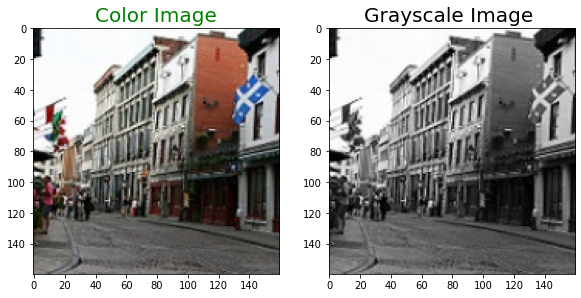

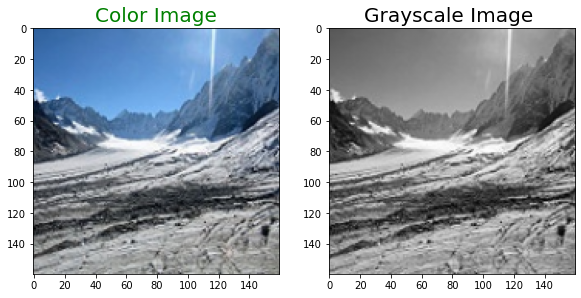

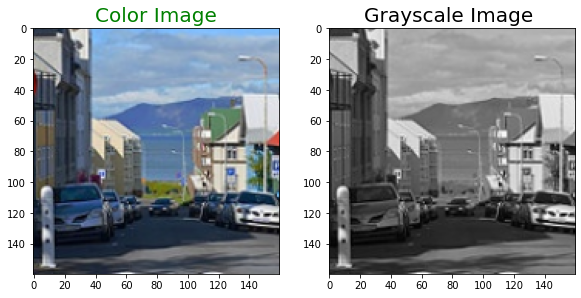

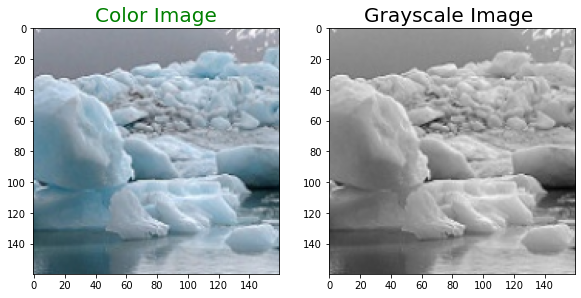

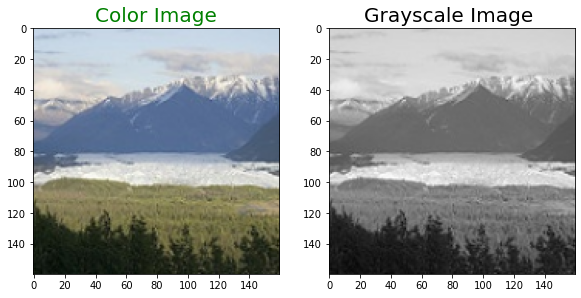

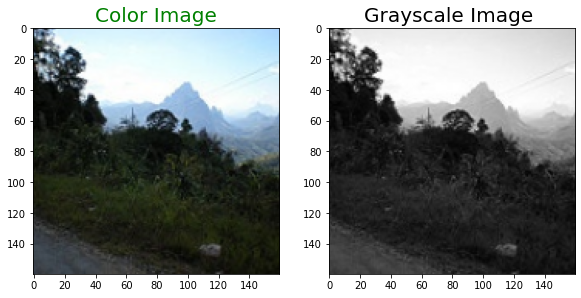

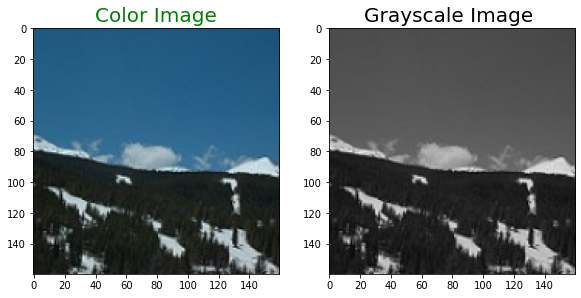

In [6]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [7]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [8]:
# def model1() :
#     inp = tf.keras.layers.Input(shape=(160,160,3))
#     conv1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu') (inp)
#     conv2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu') (conv1)
#     conv3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu') (conv2)
#     conv4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu') (conv3)
#     convt1 = tf.keras.layers.Conv2DTranspose(128,3,padding='same',activation='relu') (conv4)
#     convt2 = tf.keras.layers.Conv2DTranspose(64,3,padding='same',activation='relu') (convt1)
#     convt3 = tf.keras.layers.Conv2DTranspose(32,3,padding='same',activation='relu') (convt2)
#     convt4 = tf.keras.layers.Conv2DTranspose(16,3,padding='same',activation='relu') (convt3)
#     out = tf.keras.layers.Conv2DTranspose(3,3,padding='same',activation='sigmoid') (convt4)
    
#     model = tf.keras.models.Model(inp,out)
#     model.summary()
#     return model

# model1 = model1()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 160, 160, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 160, 128)     73856     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 160, 160, 128)     147584    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 160, 160, 64)      73792 

In [19]:
def model1() :
    inp = tf.keras.layers.Input(shape=(160,160,3))
    conv1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu') (inp)
    conv2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu') (conv1)
    conv3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu') (conv2)
    conv4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu') (conv3)
    convt1 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu') (conv4)
    convt2 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu') (convt1)
    convt3 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu') (convt2)
    convt4 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu') (convt3)
    out = tf.keras.layers.Conv2D(3,3,padding='same',activation='sigmoid') (convt4)
    
    model = tf.keras.models.Model(inp,out)
    model.summary()
    return model

model1 = model1()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 160, 160, 64)      18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 160, 160, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 160, 160, 128)     147584    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 160, 160, 64)      7379

In [21]:
model1.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001), loss='mse')
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 160, 160, 64)      18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 160, 160, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 160, 160, 128)     147584    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 160, 160, 64)      7379

In [23]:
epochs = 25
batch_size = 64

history1 = model1.fit(train_g, train_c, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_gray_image, test_color_image))

Epoch 1/25
86/86 [==============================] - 68s 787ms/step - loss: 0.0248 - val_loss: 0.0108
Epoch 2/25
86/86 [==============================] - 63s 731ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 3/25
86/86 [==============================] - 66s 764ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 4/25
86/86 [==============================] - 66s 765ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 5/25
86/86 [==============================] - 66s 770ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 6/25
86/86 [==============================] - 66s 766ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 7/25
86/86 [==============================] - 66s 768ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 8/25
86/86 [==============================] - 66s 770ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 9/25
86/86 [==============================] - 66s 768ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 10/25
86/86 [==============================] - 66s 767ms/step - loss: 0.0059 - val_lo

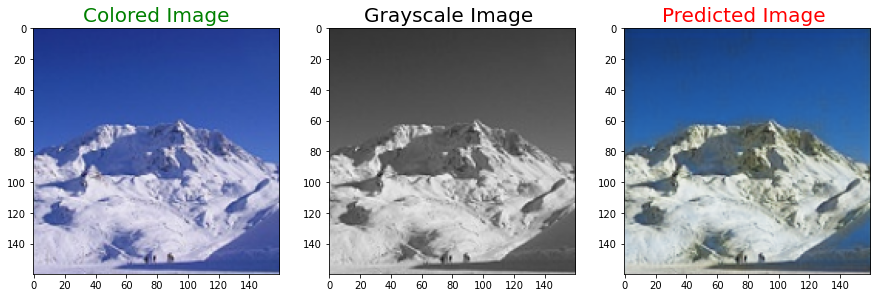

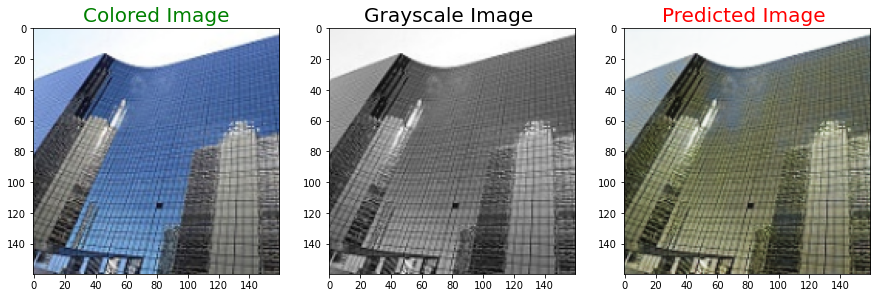

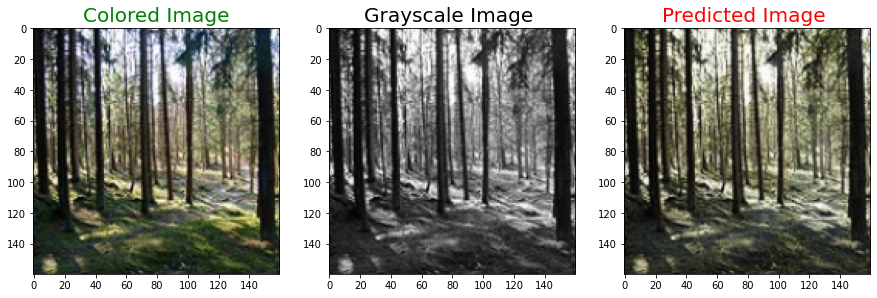

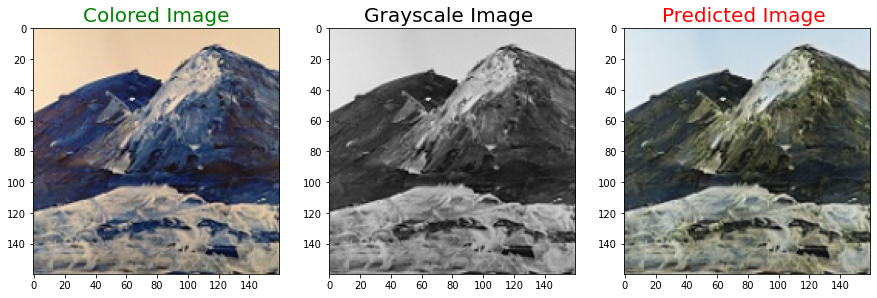

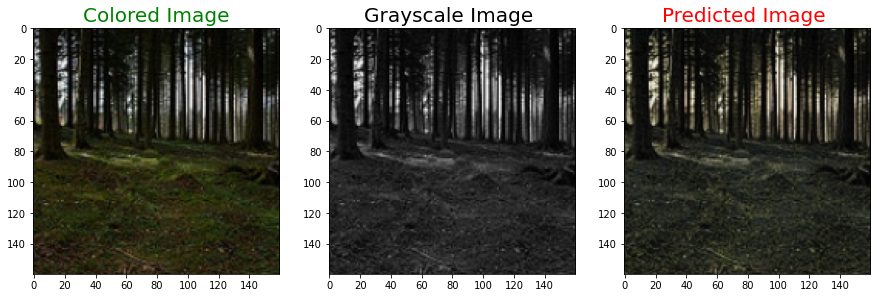

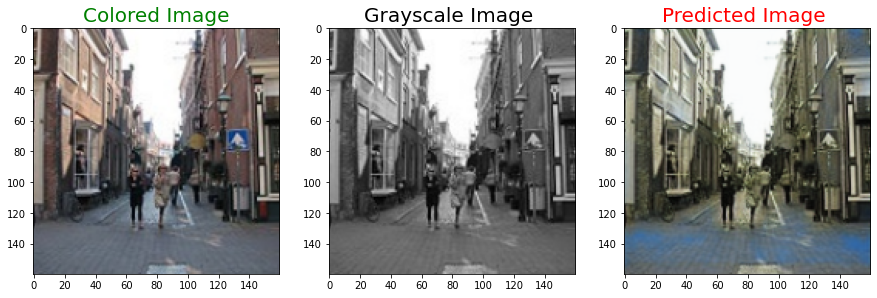

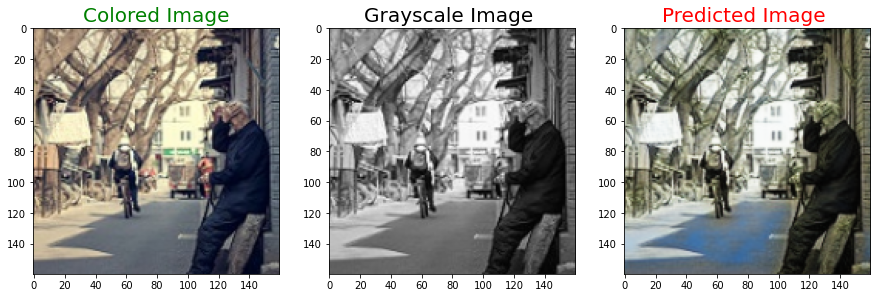

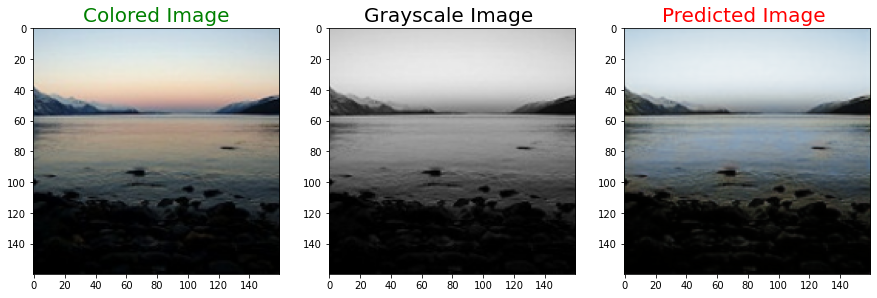

In [38]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Colored Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(100,108):
    predicted = np.clip(model1.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

 